In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.datasets import make_blobs

In [2]:
def plot_clusters(data, ground_truth):
    plt.figure(figsize=(10, 10))
    plt.scatter(data[:, 0], data[:, 1], c=ground_truth)
    plt.grid()

# Sequential K-Means

In [136]:
def predict_labels(points, centroids):
    distances = np.zeros((centroids.shape[0], points.shape[0]))
    for i, centroid in enumerate(centroids):
      dist = np.sqrt(np.sum((points - centroid)**2, axis=1))
      distances[i] = dist
    return np.argmin(distances, axis=0)

In [137]:
def update_centroids(points, closest, centroids):
    new_centeroids = np.zeros((centroids.shape[0], centroids.shape[1]))
    for i in range(centroids.shape[0]):
      class_points = points[closest == i]
      new_centeroids[i] = np.mean(class_points, axis=0)
    return new_centeroids

In [138]:
def sequential_KMeans(data, n_clusters, iterations):
    random_indices = np.random.choice(data.shape[0], size=n_clusters, replace=False)
    centroids = data[random_indices]

    for _ in range(iterations):
        centroid_labels = predict_labels(data, centroids)
        centroids = update_centroids(data, centroid_labels, centroids)

    return centroids, centroid_labels

In [164]:
SEED = 0
CLUSTERS = 4
MAX_ITERS = 1000
np.random.seed(SEED)

In [165]:
X_train, true_labels = make_blobs(n_samples=1000, centers=CLUSTERS, random_state=SEED)

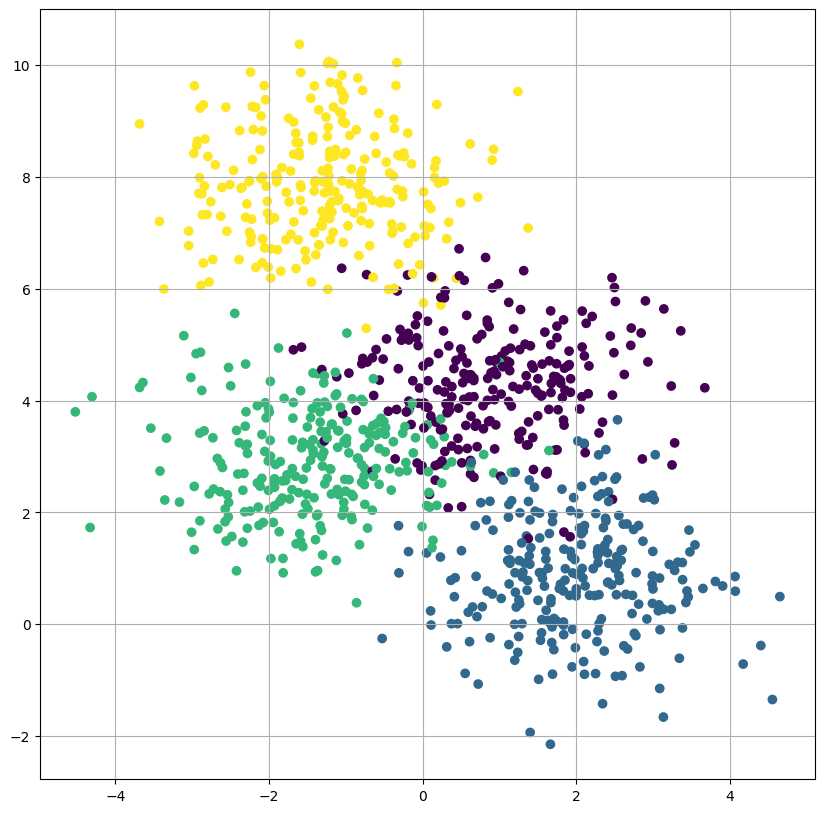

In [166]:
plot_clusters(X_train, true_labels)

In [167]:
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

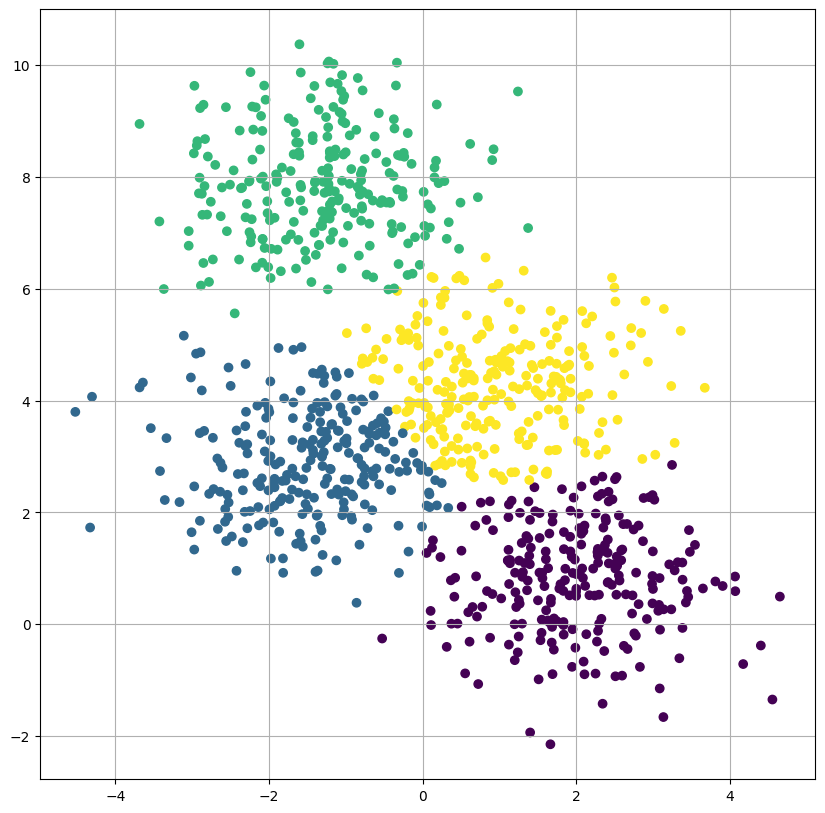

In [168]:
plot_clusters(X_train, predicted_labels)

In [11]:
SEED = 42
CLUSTERS = 25
MAX_ITERS = 600
np.random.seed(SEED)

X_train, true_labels = make_blobs(n_samples=5000, centers=CLUSTERS, random_state=SEED)

In [12]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

5.3 s ± 2.69 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Numba

In [144]:
import numba

In [145]:
@numba.njit
def numba_predict_labels(points, centroids):
    distances = np.zeros((centroids.shape[0], points.shape[0]))
    for i, centroid in enumerate(centroids):
      dist = np.sqrt(np.sum((points - centroid)**2, axis=1))
      distances[i] = dist
    return np.argmin(distances, axis=0)

In [146]:
@numba.njit
def mean_numba(a):
    res = []
    for i in numba.prange(a.shape[1]):
        res.append(a[:, i].mean())
    return np.array(res)

In [147]:
@numba.njit
def numba_update_centroids(points, closest, centroids):
    new_centeroids = np.zeros((centroids.shape[0], centroids.shape[1]))
    for i in range(centroids.shape[0]):
      class_points = points[closest == i]
      new_centeroids[i] = mean_numba(class_points)
    return new_centeroids

In [148]:
@numba.njit
def numba_KMeans(data, n_clusters, iterations):
    random_indices = np.random.choice(data.shape[0], size=n_clusters, replace=False)
    centroids = data[random_indices]

    for _ in range(iterations):
        centroid_labels = numba_predict_labels(data, centroids)
        centroids = numba_update_centroids(data, centroid_labels, centroids)

    return centroids, centroid_labels

In [169]:
SEED = 0
CLUSTERS = 4
MAX_ITERS = 1000
np.random.seed(SEED)

In [170]:
X_train, true_labels = make_blobs(n_samples=1000, centers=CLUSTERS, random_state=SEED)

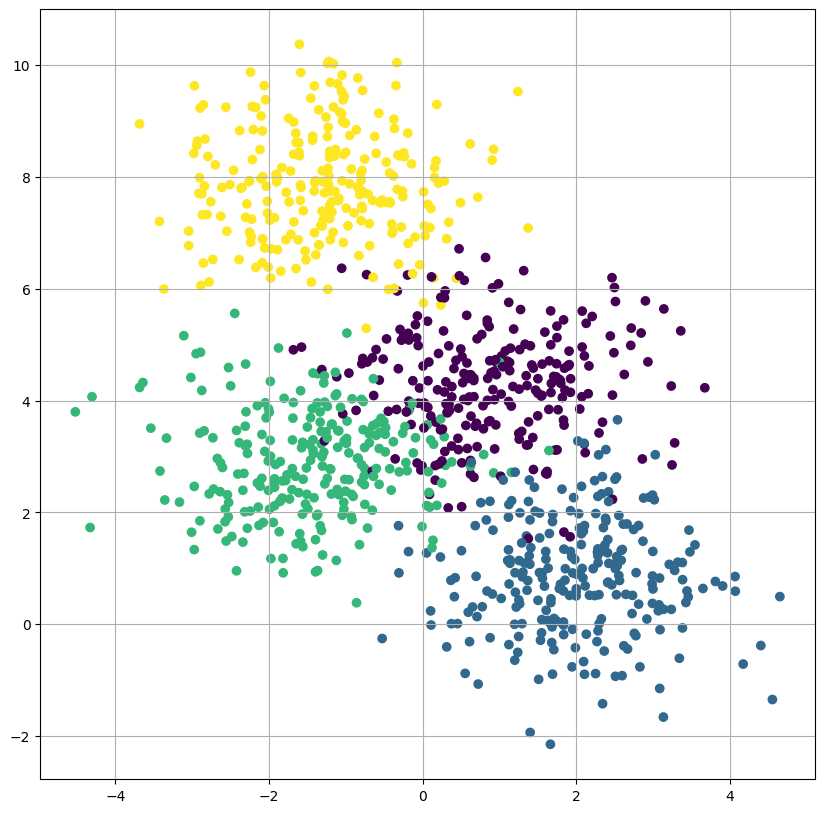

In [171]:
plot_clusters(X_train, true_labels)

In [172]:
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

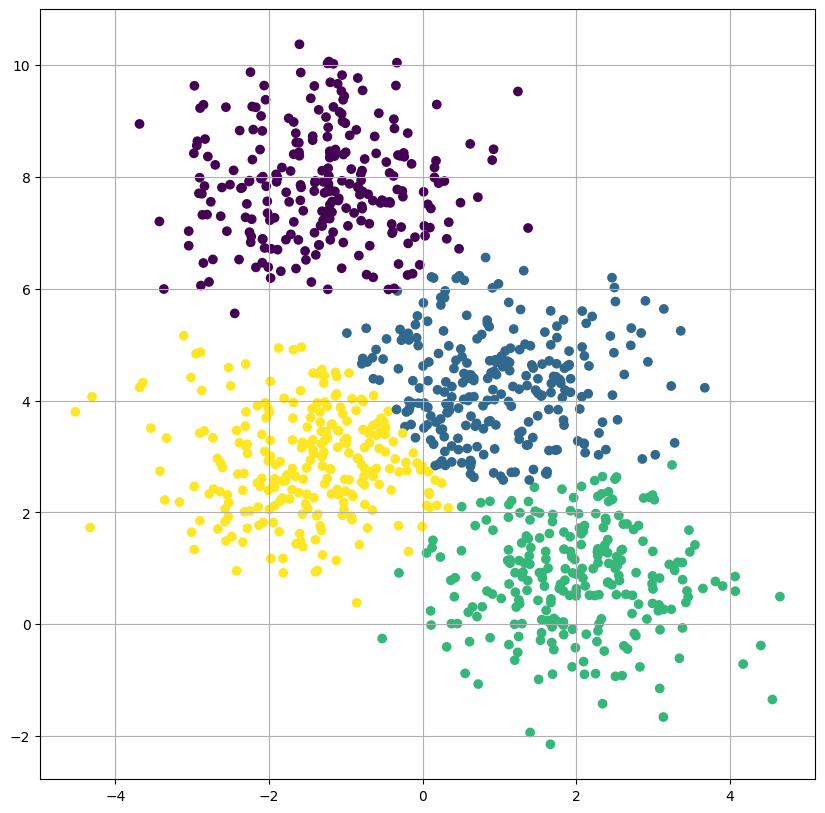

In [173]:
plot_clusters(X_train, predicted_labels)

In [23]:
SEED = 42
CLUSTERS = 25
MAX_ITERS = 600
np.random.seed(SEED)

X_train, true_labels = make_blobs(n_samples=5000, centers=CLUSTERS, random_state=SEED)

In [24]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

1.07 s ± 214 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## CuPY

In [174]:
import cupy as cp
import numpy as np
from sklearn.datasets import make_blobs

In [175]:
@cp.fuse
def eucl(points, centroid):
  return cp.sqrt(cp.sum((points - centroid)**2, axis=1))

In [176]:
def cuda_predict_labels(points, centroids, n_clusters, n_points):
    distances = cp.zeros((n_clusters, n_points))
    for i, centroid in enumerate(centroids):
      distances[i] = eucl(points, centroid)
    return cp.argmin(distances, axis=0)

In [177]:
def cuda_update_centroids(points, closest, centroids, n_clusters, sz=2):
    new_centeroids = cp.zeros((n_clusters, sz))
    for i in range(n_clusters):
      class_points = points[closest == i]
      new_centeroids[i] = cp.mean(class_points, axis=0)
    return new_centeroids

In [178]:
def cuda_KMeans(data, n_points, n_clusters, iterations):
    random_indices = cp.random.choice(n_points, size=n_clusters, replace=False)
    centroids = data[random_indices]

    for _ in range(iterations):
        centroid_labels = cuda_predict_labels(data, centroids, n_clusters, n_points)
        centroids = cuda_update_centroids(data, centroid_labels, centroids, n_clusters)

    return centroids.get(), centroid_labels.get()

In [179]:
SEED = 0
CLUSTERS = 4
MAX_ITERS = 1000
np.random.seed(SEED)

In [180]:
X_train, true_labels = make_blobs(n_samples=1000, centers=CLUSTERS, random_state=SEED)

In [181]:
X = cp.asarray(X_train)

In [184]:
centroids, predicted_labels = cuda_KMeans(X, 1000, CLUSTERS, MAX_ITERS)

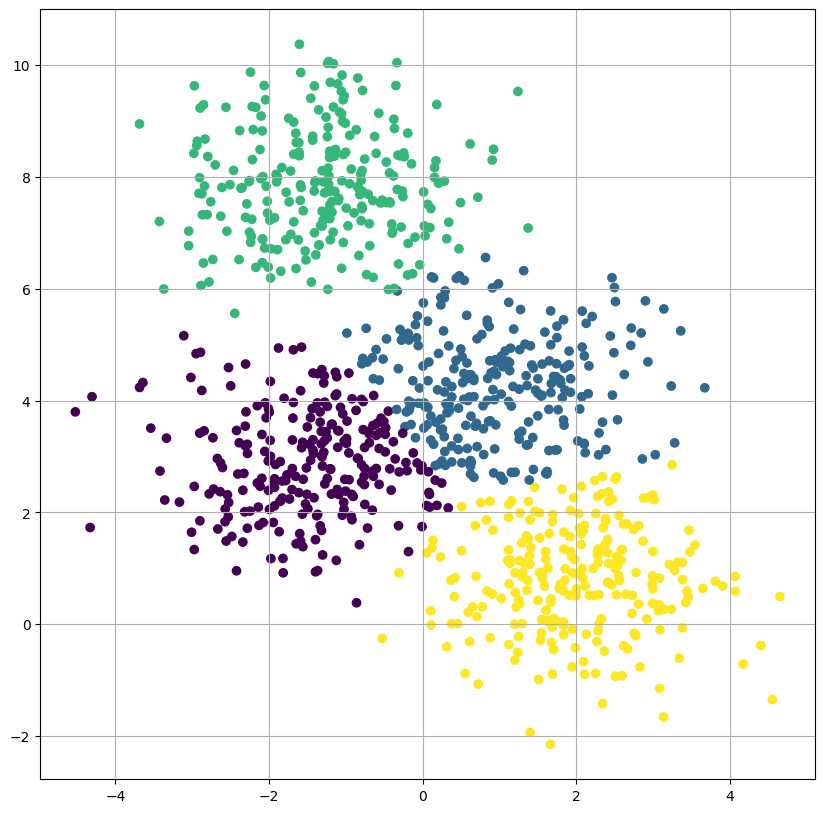

In [185]:
plot_clusters(X_train, predicted_labels)

In [35]:
SEED = 42
CLUSTERS = 25
MAX_ITERS = 600
np.random.seed(SEED)

X_train, true_labels = make_blobs(n_samples=1000, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [38]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, 1000, CLUSTERS, MAX_ITERS)

## Compare

In [43]:
SEED = 42
MAX_ITERS = 600
CLUSTERS = 50
np.random.seed(SEED)

1000

In [44]:
samples = 1000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [45]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

2.5 s ± 964 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

363 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

13.7 s ± 155 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


2000

In [49]:
samples = 2000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [50]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

3.48 s ± 565 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

872 ms ± 158 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

13.6 s ± 83.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


3000

In [53]:
samples = 3000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [54]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

4.44 s ± 436 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

1.24 s ± 216 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

15.7 s ± 2.45 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


4000

In [57]:
samples = 4000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [58]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

7.49 s ± 1.43 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

1.94 s ± 568 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

17 s ± 2.15 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


5000

In [61]:
samples = 5000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [62]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

8.63 s ± 1.46 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

2.21 s ± 490 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

16.1 s ± 2.64 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


6000

In [65]:
samples = 6000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [66]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

8.27 s ± 407 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

2.33 s ± 282 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

13.7 s ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


7000

In [69]:
samples = 7000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [70]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

9.51 s ± 344 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

2.71 s ± 303 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

13.8 s ± 149 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


8000

In [73]:
samples = 8000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [74]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

10.8 s ± 292 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

3.09 s ± 299 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

13.7 s ± 84.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


9000

In [77]:
samples = 9000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [78]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

12.2 s ± 225 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

3.51 s ± 384 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

13.9 s ± 367 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


10000

In [81]:
samples = 10000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [82]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

13.5 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

4.1 s ± 492 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [84]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

13.6 s ± 61.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


12000

In [85]:
samples = 12000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [86]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

16.4 s ± 407 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

4.91 s ± 454 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

15.2 s ± 332 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


14000

In [89]:
samples = 14000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [90]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

18.6 s ± 524 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

5.65 s ± 407 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [92]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

15 s ± 178 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


16000

In [93]:
samples = 16000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [94]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

24.3 s ± 727 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [95]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

9.73 s ± 199 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

14.9 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


18000

In [97]:
samples = 18000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [98]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

27.1 s ± 355 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [99]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

10.9 s ± 196 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

15.1 s ± 295 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


20000

In [101]:
samples = 20000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [102]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

30.5 s ± 524 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [103]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

12.5 s ± 214 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [104]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

15.1 s ± 228 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


25000

In [105]:
samples = 25000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [106]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

37.5 s ± 904 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

15.8 s ± 517 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [108]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

16 s ± 659 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


30000

In [109]:
samples = 30000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [110]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

44 s ± 1.12 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [111]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

20.2 s ± 451 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [112]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

16.6 s ± 640 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


40000

In [113]:
samples = 40000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [114]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

57.3 s ± 795 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [115]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

27.1 s ± 606 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [116]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

16.3 s ± 299 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


50000

In [117]:
samples = 50000
X_train, true_labels = make_blobs(n_samples=samples, centers=CLUSTERS, random_state=SEED)
X = cp.asarray(X_train)

In [118]:
%%timeit
centroids, predicted_labels = sequential_KMeans(X_train, CLUSTERS, MAX_ITERS)

1min 10s ± 899 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [119]:
%%timeit
centroids, predicted_labels = numba_KMeans(X_train, CLUSTERS, MAX_ITERS)

35.2 s ± 261 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [120]:
%%timeit
centroids, predicted_labels = cuda_KMeans(X, samples, CLUSTERS, MAX_ITERS)

16.3 s ± 432 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [128]:
ox = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12000, 14000, 16000, 18000, 20000, 25000, 30000, 40000, 50000]

In [129]:
ctime = [2.5, 3.48, 4.44, 7.49, 8.63, 8.27, 9.51, 10.8, 12.2, 13.5, 16.4, 18.6, 24.3, 27.1, 30.5, 37.5, 44, 57.3, 70]
ntime = [0.36, 0.87, 1.24, 1.94, 2.21, 2.33, 2.71, 3.09, 3.51, 4.1, 4.91, 5.65, 9.73, 10.9, 12.5, 15.8, 20.2, 27.1, 35.2]
gtime = [13.7, 13.6, 15.7, 17, 16.1, 13.7, 13.8, 13.7, 13.9, 13.6, 15.2, 15, 14.9, 15.1, 15.1, 16, 16.6, 16.3, 16.3]

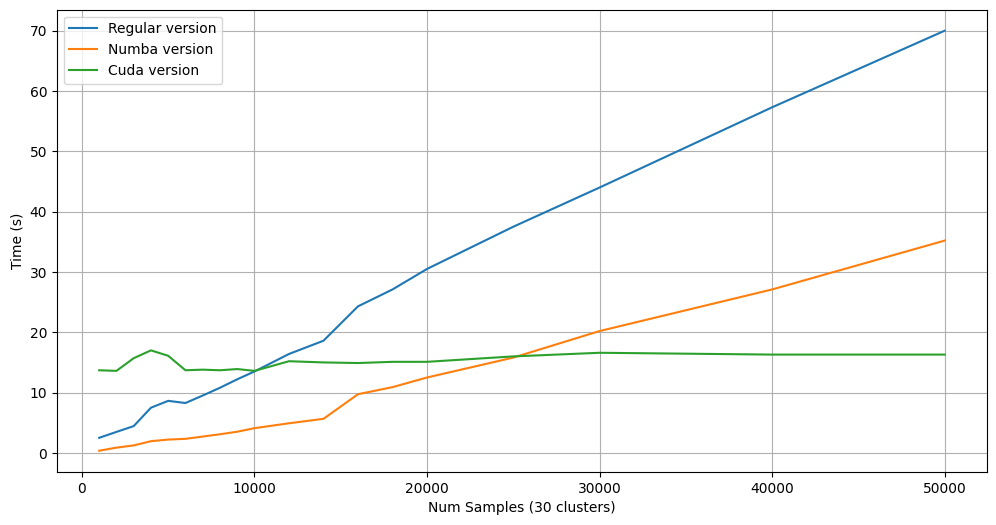

In [135]:
plt.figure(figsize=(12, 6))
plt.plot(ox, ctime, label='Regular version')
plt.plot(ox, ntime, label='Numba version')
plt.plot(ox, gtime, label='Cuda version')
plt.ylabel('Time (s)')
plt.xlabel('Num Samples (30 clusters)')
plt.legend()
plt.grid()
plt.savefig('plot.png', dpi=400)